# Dataset Preparation

In [1]:
# basic_nodes
class plus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None
      
  def forward(self,x,y):
    self._x, self._y = x, y
    self._z = self._x + self._y
    return self._z
  
  def backward(self, dz): # dz = dJ/dz
    return dz*1,dz*1 #dJ/dx= dJ/dz * dz/dx, dJ/dy

class minus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x, self._y = x, y
    self._z = self._x - self._y
    return self._z

  def backward(self, dz):
    return 1*dz, -1*dz

class mul_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x , self._y = x, y
    self._z = self._x * self._y
    return self._z

  def backward(self, dz):
    return dz*self._y, dz*self._x # dJ/dz * dz/dx, dJ/dy

class square_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = self._x * self._x
    return self._z

  def backward(self, dz):
    return dz*(2*self._x)

class mean_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = np.mean(self._x) # z = 1/n *(x1+x2+...+xn)
    return self._z

  def backward(self, dz):
    dx = dz*1/len(self._x)*np.ones_like(self._x) # dJ/dx1 = dJ/dz * dz/dx1 = dJ/dz * (1/n)
    return dx

In [2]:
class dataset_generator:
  def __init__(self, feature_dim = 1, n_sample = 100, noise = 0):
    self._feature_dim = feature_dim
    self._n_sample = n_sample
    self._noise = noise

    self._coefficient = None
    self._init_set_coefficient()

    self._distribution_params = None
    self._init_distribution_params()

  def _init_set_coefficient(self):
    self._coefficient = [1 for _ in range(self._feature_dim)] + [0]  # weights + bias
  
  def _init_distribution_params(self):
    self._distribution_params = {f:{'mean':0, 'std':1} for f in range(1, self._feature_dim)}

  def set_n_sample(self, n_sample):
    self._n_sample = n_sample 

  def set_noise(self, noise):
    self._noise = _noise

  def set_coefficient(self, coefficient_list):
     self._coefficient = coefficient_list

  def set_distribution_params(self, distribution_params):
      for param_key, param_value in distribution_params.items():
        self._distribution_params[param_key] = param_value

  def make_dataset(self):
    x_data = np.random.normal(0, 1, size = (self._n_sample,
                                            self._feature_dim))
    y_data = np.zeros(shape = (self._n_sample, 1))
    for feature_idx in range(self._feature_dim):
      y_data += self._coefficient[feature_idx] * x_data[:,feature_idx].reshape(-1,1)
    y_data += self._coefficient[-1] # bias
    y_data += self._noise*np.random.normal(0,1,size=(self._n_sample, 1))

    return x_data, y_data

  def dataset_visualizer(self):
    if self._feature_dim == 1:
      plt.style.use('seaborn')

      fig, ax = plt.subplots(figsize=(10,10))
      ax.plot(x_data, y_data, 'bo',
              alpha=0.3,
              markersize=20)
      ax.tick_params(axis='both',
                     labelsize=30)
      ax.set_title("Dataset", fontsize=40, color='darkred')
      ax.set_xlabel('X data', fontsize=30, alpha=0.6)
      ax.set_ylabel('Y data', fontsize=30, alpha=0.6)

    else:
      class feature_dim_error(Exception):
        pass
      raise feature_dim_error("Visualization is valid for only feature_dim == 1")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('seaborn')
np.random.seed(0)

##### Dataset Preparation
dataset_gen = dataset_generator(feature_dim=2, n_sample= 100)
dataset_gen.set_coefficient([3,3,3])
distribution_params = {
    'feature_0' : {'mean':0, 'std':1},
    'feature_1' : {'mean':0, 'std':1}
}
dataset_gen.set_distribution_params(distribution_params)

x_data, y_data = dataset_gen.make_dataset()
data = np.hstack((x_data, y_data))

# Model/Loss Setting

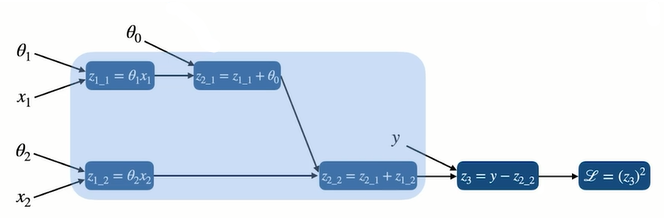

In [11]:
##### Model/Loss Implementation
# Model
node1_1 = mul_node()
node1_2 = mul_node()
node2_1 = plus_node()
node2_2 = plus_node()

# Loss
node3 = minus_node()
node4 = square_node()

# Learning 

In [15]:
##### Learning
th2, th1, th0 = 0.5, 0.5, 0.5
epochs, lr = 3, 0.005

th_accum = np.array([th2, th1, th0]).reshape(-1,1)
loss_list = []

for epoch in range(epochs):
  for data_idx, (x2, x1, y) in enumerate(data):
    # forward propragation
    z1_1 = node1_1.forward(th1, x1)
    z1_2 = node1_2.forward(th2, x2)
    z2_1 = node2_1.forward(th0, z1_1)
    z2_2 = node2_2.forward(z2_1, z1_2)
    z3 = node3.forward(y, z2_2)
    l = node4.forward(z3)

    # backward propagation
    dz3 = node4.backward(1)
    dy, dz2_2 = node3.backward(dz3)
    dz2_1, dz1_2 = node2_2.backward(dz2_2)
    dth0, dz1_1 = node2_1.backward(dz2_1)
    dth2, dx2 = node1_2.backward(dz1_2)
    dth1, dx1 = node1_1.backward(dz1_1)

    # update
    th2 = th2 - lr*dth2
    th1 = th1 - lr*dth1
    th0 = th0 - lr*dth0

    th_current = np.array([th2, th1, th0]).reshape(-1,1)
    th_accum = np.hstack((th_accum, th_current))
    loss_list.append(l)

# Result Visualization

Text(0.5, 1.0, 'Loss')

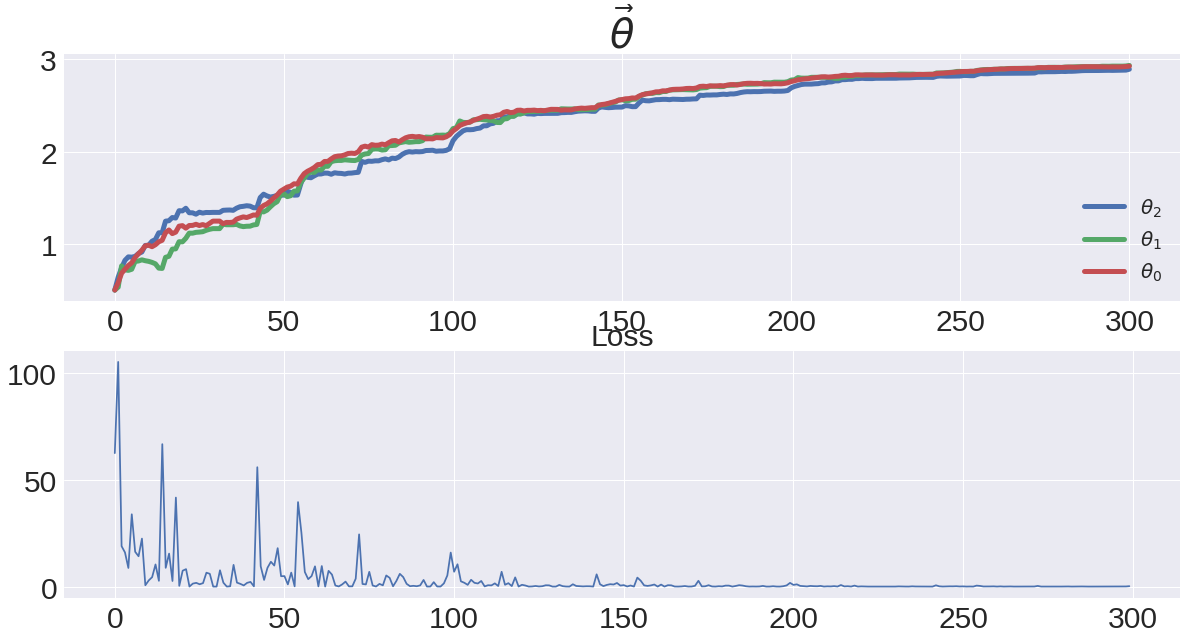

In [18]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(th_accum[0], label = r'$\theta_{2}$', linewidth = 5)
ax[0].plot(th_accum[1], label = r'$\theta_{1}$', linewidth = 5)
ax[0].plot(th_accum[2], label = r'$\theta_{0}$', linewidth = 5)

ax[0].tick_params(axis='both', labelsize=30)
ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
ax[0].legend(loc='lower right', fontsize=20)

ax[1].plot(loss_list)
ax[1].tick_params(axis='both', labelsize=30)
ax[1].set_title('Loss', fontsize=30)

------------------------------------------------------------------------

# for M Features_규칙 확인

index를 맞춰주기 위해서 앞에 빈 컬럼을 만듬

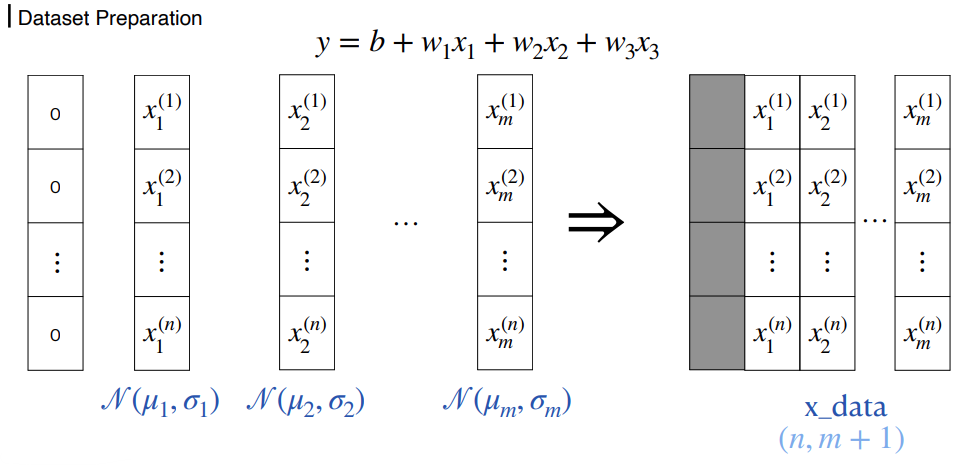

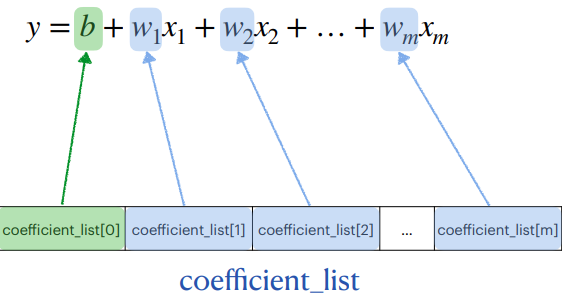

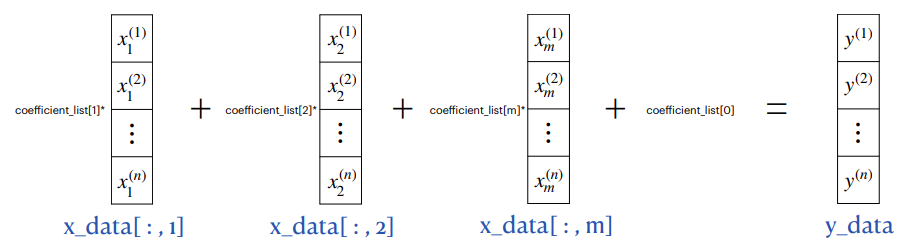

## Dataset Preparation

feature 3개로 정하고 규칙찾기

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('seaborn')
np.random.seed(0)

n_sample = 100
feature_dim = 3
coefficient_list = [3, 3, 3, 3] # bias, w1, w2, w3
distribution_params = {
    1: {'mean':0, 'std':1},
    2: {'mean':0, 'std':1},
    3: {'mean':0, 'std':1},
}

In [24]:
y_data = np.zeros(shape = (n_sample, 1))
x_data = np.zeros(shape = (n_sample, 1)) # index를 맞추기 위한 빈 인덱스 생성

for feature_idx in range(1, feature_dim + 1):
  feature_data = np.random.normal(loc = distribution_params[feature_idx]['mean'],
                                  scale = distribution_params[feature_idx]['std'],
                                  size = (n_sample, 1))
  x_data = np.hstack((x_data, feature_data))
  y_data += coefficient_list[feature_idx]*feature_data

y_data += coefficient_list[0] # bias 더함

print(x_data.shape, y_data.shape)

(100, 4) (100, 1)


## Model/Loss Implementation

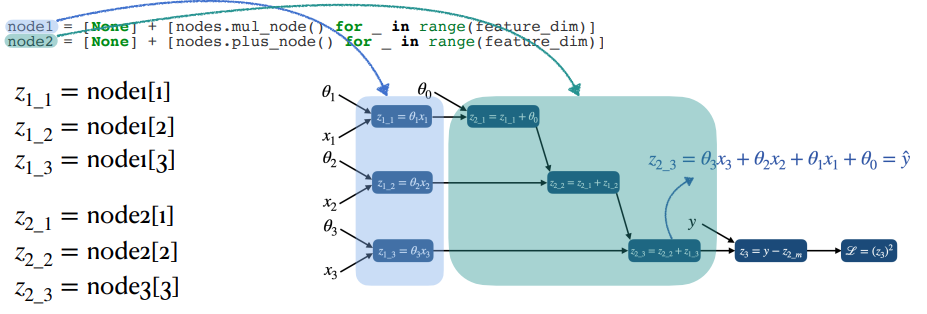

In [27]:
# model
node1 = [None] + [mul_node() for _ in range(feature_dim)]
node2 = [None] + [plus_node() for _ in range(feature_dim)]

# loss
node3 = minus_node()
node4 = square_node()

## Data Sample Extraction

In [38]:
th_list = [0.5, 0.5, 0.5, 0.5] # inital theta
epochs, lr = 50, 0.001

th_accum = np.array(th_list).reshape(-1,1)
loss_list = []

for epoch in range(epochs):
  for data_idx, (X, y) in enumerate(zip(x_data, y_data)):
    
    # forward propagation
    z1_1 = node1[1].forward(th_list[1], X[1])
    z1_2 = node1[2].forward(th_list[2], X[2])
    z1_3 = node1[3].forward(th_list[3], X[3])

    z2_1 = node2[1].forward(th_list[0], z1_1)
    z2_2 = node2[2].forward(z2_1, z1_2)
    z2_3 = node2[3].forward(z2_2, z1_3)

    z3 = node3.forward(y, z2_3)
    l = node4.forward(z3)

    # backpropagation
    dz3 = node4.backward(1)
    dy, dz2_3 = node3.backward(dz3)

    dz2_2, dz1_3 = node2[3].backward(dz2_3)
    dz2_1, dz1_2 = node2[2].backward(dz2_2)
    dth0, dz1_1 = node2[1].backward(dz2_1)

    dth3, dx3 = node1[3].backward(dz1_3)
    dth2, dx2 = node1[2].backward(dz1_2)
    dth1, dx1 = node1[1].backward(dz1_1)

    # update
    th_list[3] = th_list[3] - lr*dth3
    th_list[2] = th_list[2] - lr*dth2
    th_list[1] = th_list[1] - lr*dth1
    th_list[0] = th_list[0] - lr*dth0

    th_next = np.array(th_list).reshape(-1,1) #(4,1)
    th_accum = np.hstack((th_accum, th_next))
    loss_list.append(l)

## Result Visualization

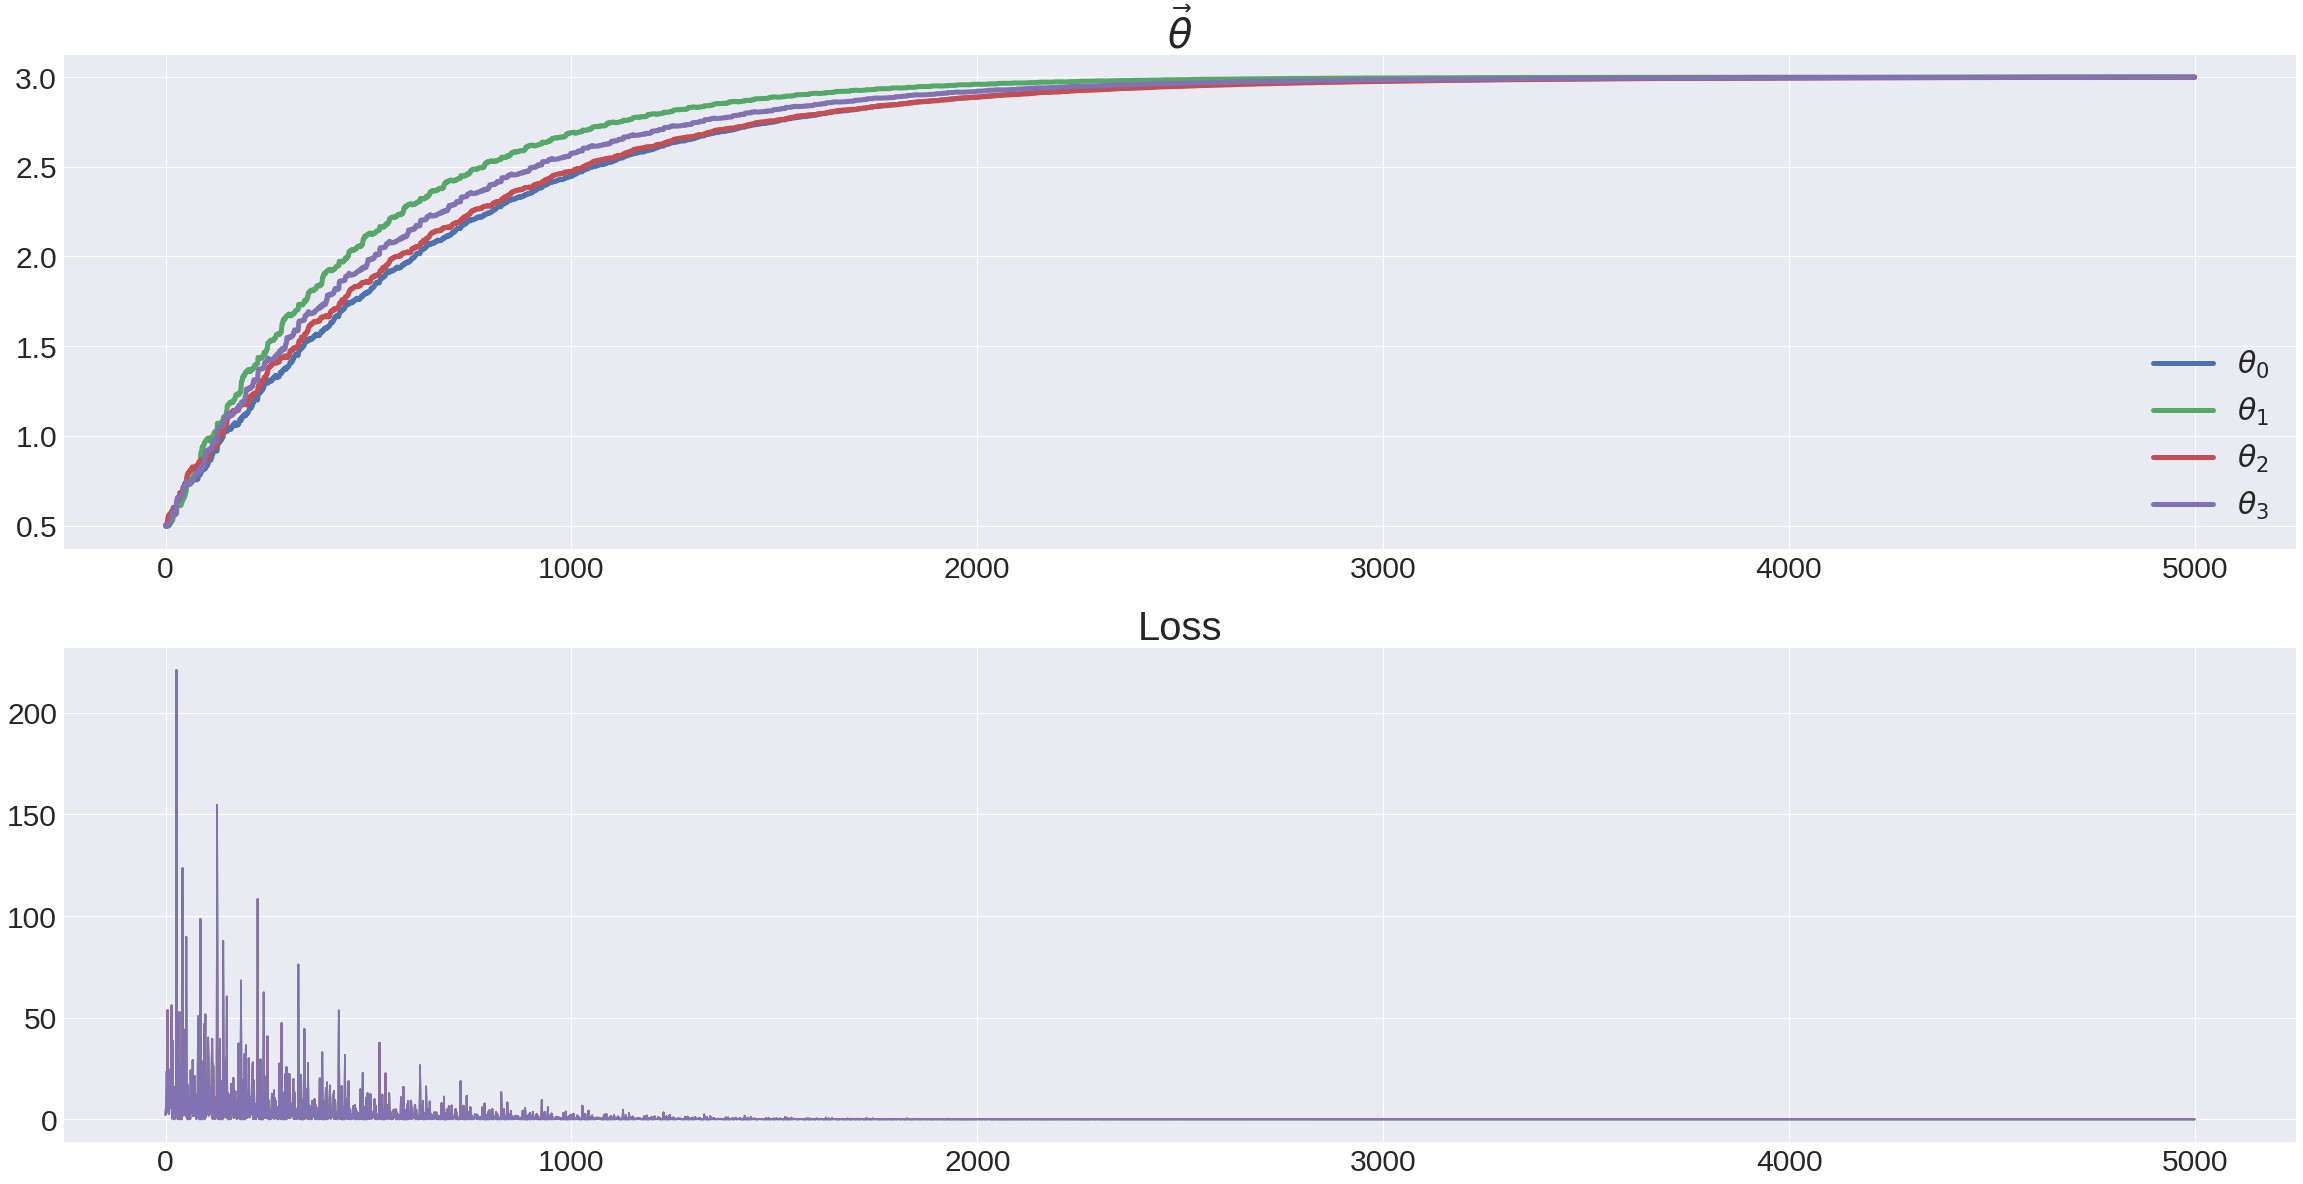

In [39]:
fig, ax = plt.subplots(2,1, figsize=(40,20))
for feature_idx in range(feature_dim + 1):
  ax[0].plot(th_accum[feature_idx], label = r'$\theta_{%d}$'%feature_idx, linewidth =5)

  ax[1].plot(loss_list)

  ax[0].legend(loc='lower right', fontsize=30)
  ax[0].tick_params(axis='both', labelsize=30)
  ax[1].tick_params(axis='both', labelsize=30)

  ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
  ax[1].set_title('Loss', fontsize=40)

# for M Features_자동화

## Learning

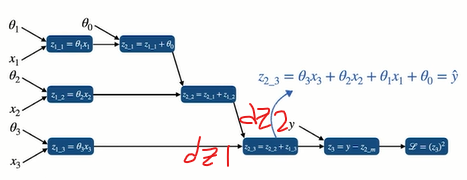

In [48]:
th_list = [0.5, 0.5, 0.5, 0.5] # inital theta
epochs, lr = 50, 0.001
th_accum = np.array(th_list).reshape(-1,1)
loss_list = []


for epoch in range(epochs):
  for data_idx, (X, y) in enumerate(zip(x_data, y_data)):
    
    # forward propagation
    z1_list = [None]*(feature_dim+1)
    z2_list, dz2_list, dz1_list, dth_list = z1_list.copy(), z1_list.copy(), z1_list.copy(), z1_list.copy()

    for node_idx in range(1, feature_dim+1):
      z1_list[node_idx] = node1[node_idx].forward(th_list[node_idx], X[node_idx])
    
    z2_list[1] = node2[1].forward(th_list[0], z1_list[1]) # theta0를 받는 다는 차이점이 있음
    for node_idx in range(2, feature_dim+1):
      z2_list[node_idx] = node2[node_idx].forward(z2_list[node_idx-1], z1_list[node_idx])
    
    z3 = node3.forward(y, z2_list[-1])
    l = node4.forward(z3)

    # backpropagation
    dz3 = node4.backward(1)
    dzy, dz2_last = node3.backward(dz3)
    dz2_list[-1] = dz2_last

    for node_idx in reversed(range(1,feature_dim+1)):
      dz2, dz1 = node2[node_idx].backward(dz2_list[node_idx])
      dz2_list[node_idx-1] = dz2
      dz1_list[node_idx] = dz1

    dth_list[0] = dz2_list[0]

    for node_idx in reversed(range(1, feature_dim+1)):
      dth, dx = node1[node_idx].backward(dz1_list[node_idx])
      dth_list[node_idx] = dth

    # Parameter update
    for th_idx in range(len(th_list)):
      th_list[th_idx] = th_list[th_idx] - lr*dth_list[th_idx]

    th_next = np.array(th_list).reshape(-1,1)
    th_accum = np.hstack((th_accum, th_next))
    loss_list.append(l)

## Result Visualization

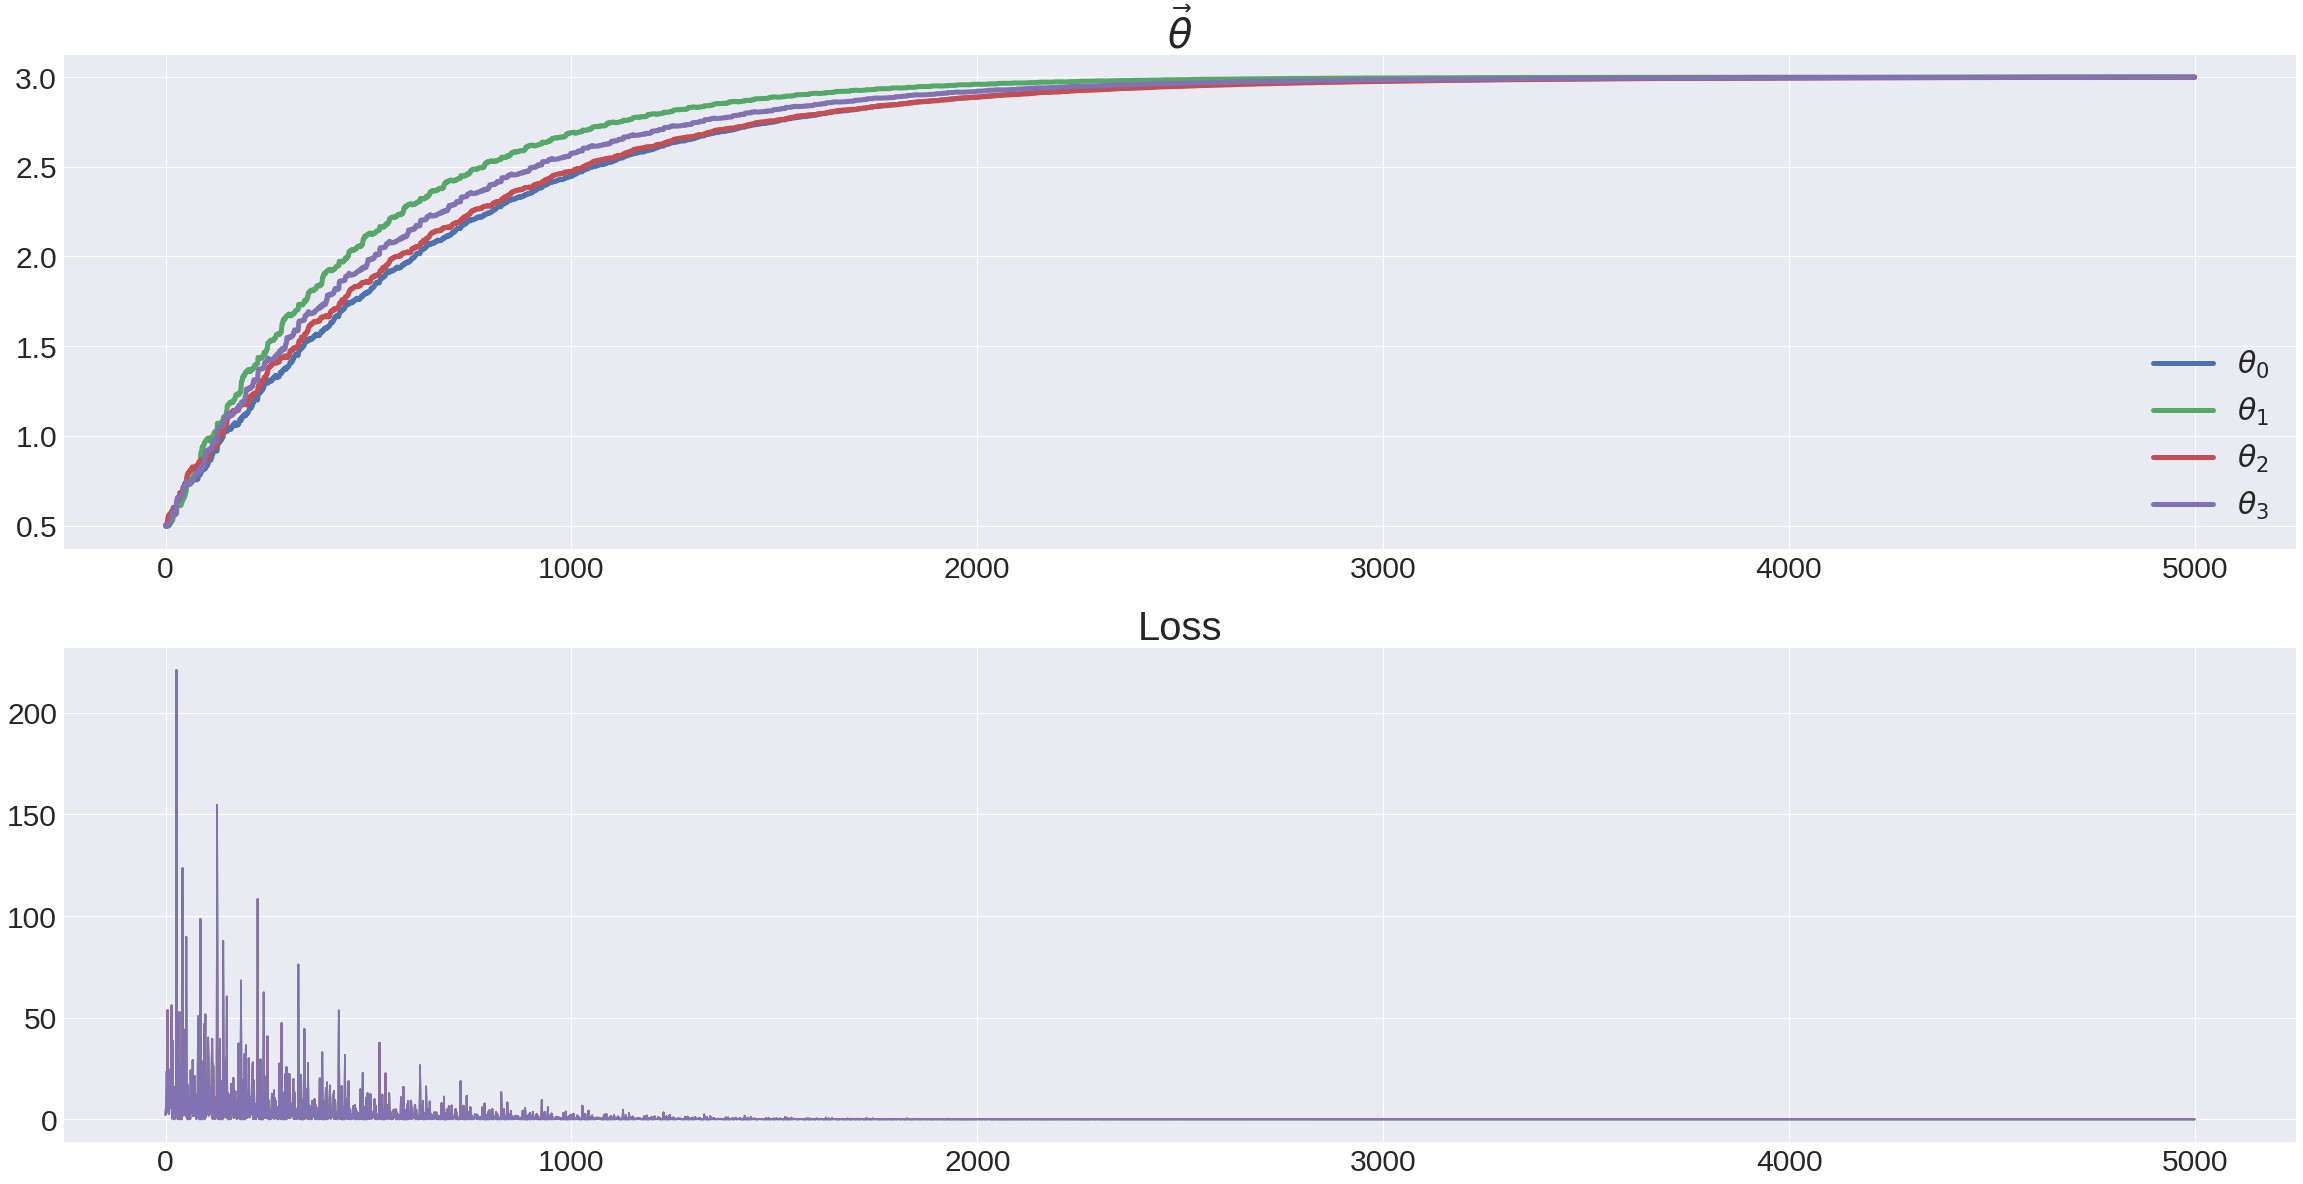

In [49]:
fig, ax = plt.subplots(2,1, figsize=(40,20))
for feature_idx in range(feature_dim + 1):
  ax[0].plot(th_accum[feature_idx], label = r'$\theta_{%d}$'%feature_idx, linewidth =5)

  ax[1].plot(loss_list)

  ax[0].legend(loc='lower right', fontsize=30)
  ax[0].tick_params(axis='both', labelsize=30)
  ax[1].tick_params(axis='both', labelsize=30)

  ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
  ax[1].set_title('Loss', fontsize=40)

# class화_Affine Function

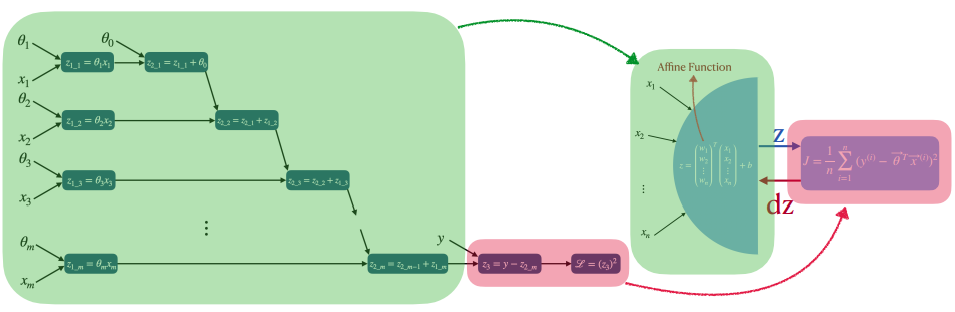

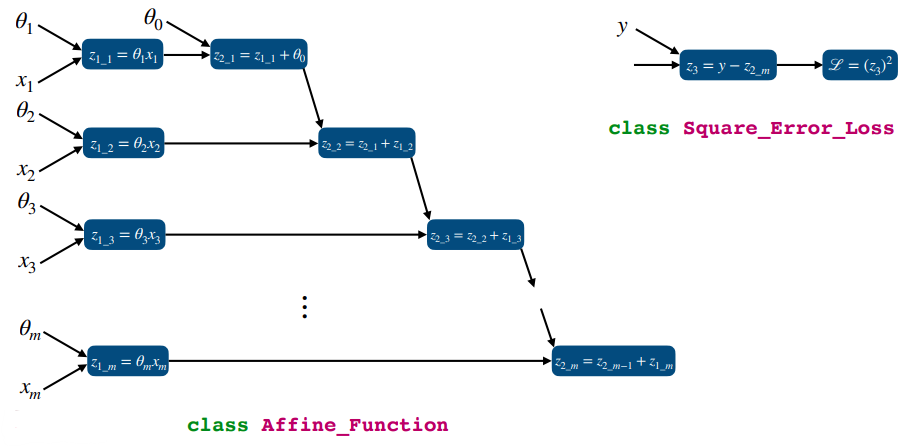

## class LR_dataset_generator

In [80]:
class LR_dataset_generator:
    def __init__(self, feature_dim, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient_list = None
        self._distribution_params = None
        
        self._dataset = None
        
        self._init_coefficient()
        self._init_distribution_params()
        
    def _init_coefficient(self):
        self._coefficient_list = [0] + [1 for _ in range(self._feature_dim)]
        
    def _init_distribution_params(self):
        self._distribution_params = {f:{'mean':0, 'std':1}
                                     for f in range(1, self._feature_dim+1)}
    
    def make_dataset(self):
        x_data = np.zeros(shape = (self._n_sample, 1))
        y_data = np.zeros(shape = (self._n_sample, 1))
        
        for f_idx in range(1, self._feature_dim + 1):
            feature_data = np.random.normal(loc = self._distribution_params[f_idx]['mean'],
                                            scale = self._distribution_params[f_idx]['std'],
                                            size = (self._n_sample, 1))
            x_data = np.hstack((x_data, feature_data))
            
            y_data += self._coefficient_list[f_idx]*feature_data
        y_data += self._coefficient_list[0]
        
        return x_data, y_data

    def set_n_sample(self, n_sample):
        self._n_sample = n_sample
    
    def set_noise(self, noise):
        self._noise = noise
    
    def set_distribution_params(self, distribution_params):
        for param_key, param_value in distribution_params.items():
            self._distribution_params[param_key] = param_value
    
    def set_coefficient(self, coefficient_list):
        self._coefficient_list = coefficient_list

## class Affine_Function

In [81]:
class Affine_Function:
  def __init__(self, feature_dim, Th):
    self._feature_dim = feature_dim
    self._Th = Th

    self._z1_list = [None] * (self._feature_dim + 1)
    self._z2_list = self._z1_list.copy()

    self._dz1_list, self._dz2_list = self._z1_list.copy(), self._z1_list.copy()
    self._dth_list = self._z1_list.copy()

    self.affine_imp()

  def affine_imp(self):
    self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
    self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]

  def forward(self, X):
    for node_idx in range(1, self._feature_dim+1):
      self._z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[node_idx])

    self._z2_list[1] = self._node2[1].forward(self._Th[0], self._z1_list[1]) 
    for node_idx in range(2, self._feature_dim+1):
      self._z2_list[node_idx] = self._node2[node_idx].forward(self._z2_list[node_idx-1], self._z1_list[node_idx])
    
    return self._z2_list[-1]

  def backward(self, dz2_last, lr):
    self._dz2_list[-1] = dz2_last

    for node_idx in reversed(range(1, self._feature_dim+1)):
      dz2, dz1 = self._node2[node_idx].backward(self._dz2_list[node_idx])
      self._dz2_list[node_idx-1] = dz2
      self._dz1_list[node_idx] = dz1
    
    self._dth_list[0] = self._dz2_list[0]
    for node_idx in reversed(range(1, self._feature_dim+1)):
      dth, _ = self._node1[node_idx].backward(self._dz1_list[node_idx])
      self._dth_list[node_idx] = dth
    
    self._Th = self._Th - lr*np.array(self._dth_list).reshape(-1,1)
    return self._Th

## class Square_Error_Loss

In [55]:
class Square_Error_Loss:
  def __init__(self):
    self.loss_imp()

  def loss_imp(self):
    self._node3 = minus_node()
    self._node4 = square_node()

  def forward(self, y, pred):
    z3 = self._node3.forward(y, pred)
    l = self._node4.forward(z3)
    return l
  
  def backward(self):
    dz3 = self._node4.backward(1)
    dy, dz2_last = self._node3.backward(dz3)
    return dz2_last

## Result_Visualization Function

In [56]:
def result_visualization(th_accum, loss_list):
  fig, ax = plt.subplots(2,1, figsize=(40,20))
  for i in range(feature_dim+1):
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 5)
  
  ax[1].plot(loss_list)

  ax[0].legend(loc='lower right', fontsize=30)
  ax[0].tick_params(axis='both', labelsize=30)
  ax[1].tick_params(axis='both', labelsize=30)

  ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
  ax[1].set_title('Loss', fontsize=40)

## Learning Preparation

In [87]:
feature_dim = 5

data_gen = LR_dataset_generator(feature_dim = feature_dim)
x_data, y_data = data_gen.make_dataset()

Th = np.array([1,2,3,4,5,6]).reshape(-1,1)
epochs, lr = 20, 0.001

th_accum = Th.reshape(-1,1)
loss_list = []

## Learning Code

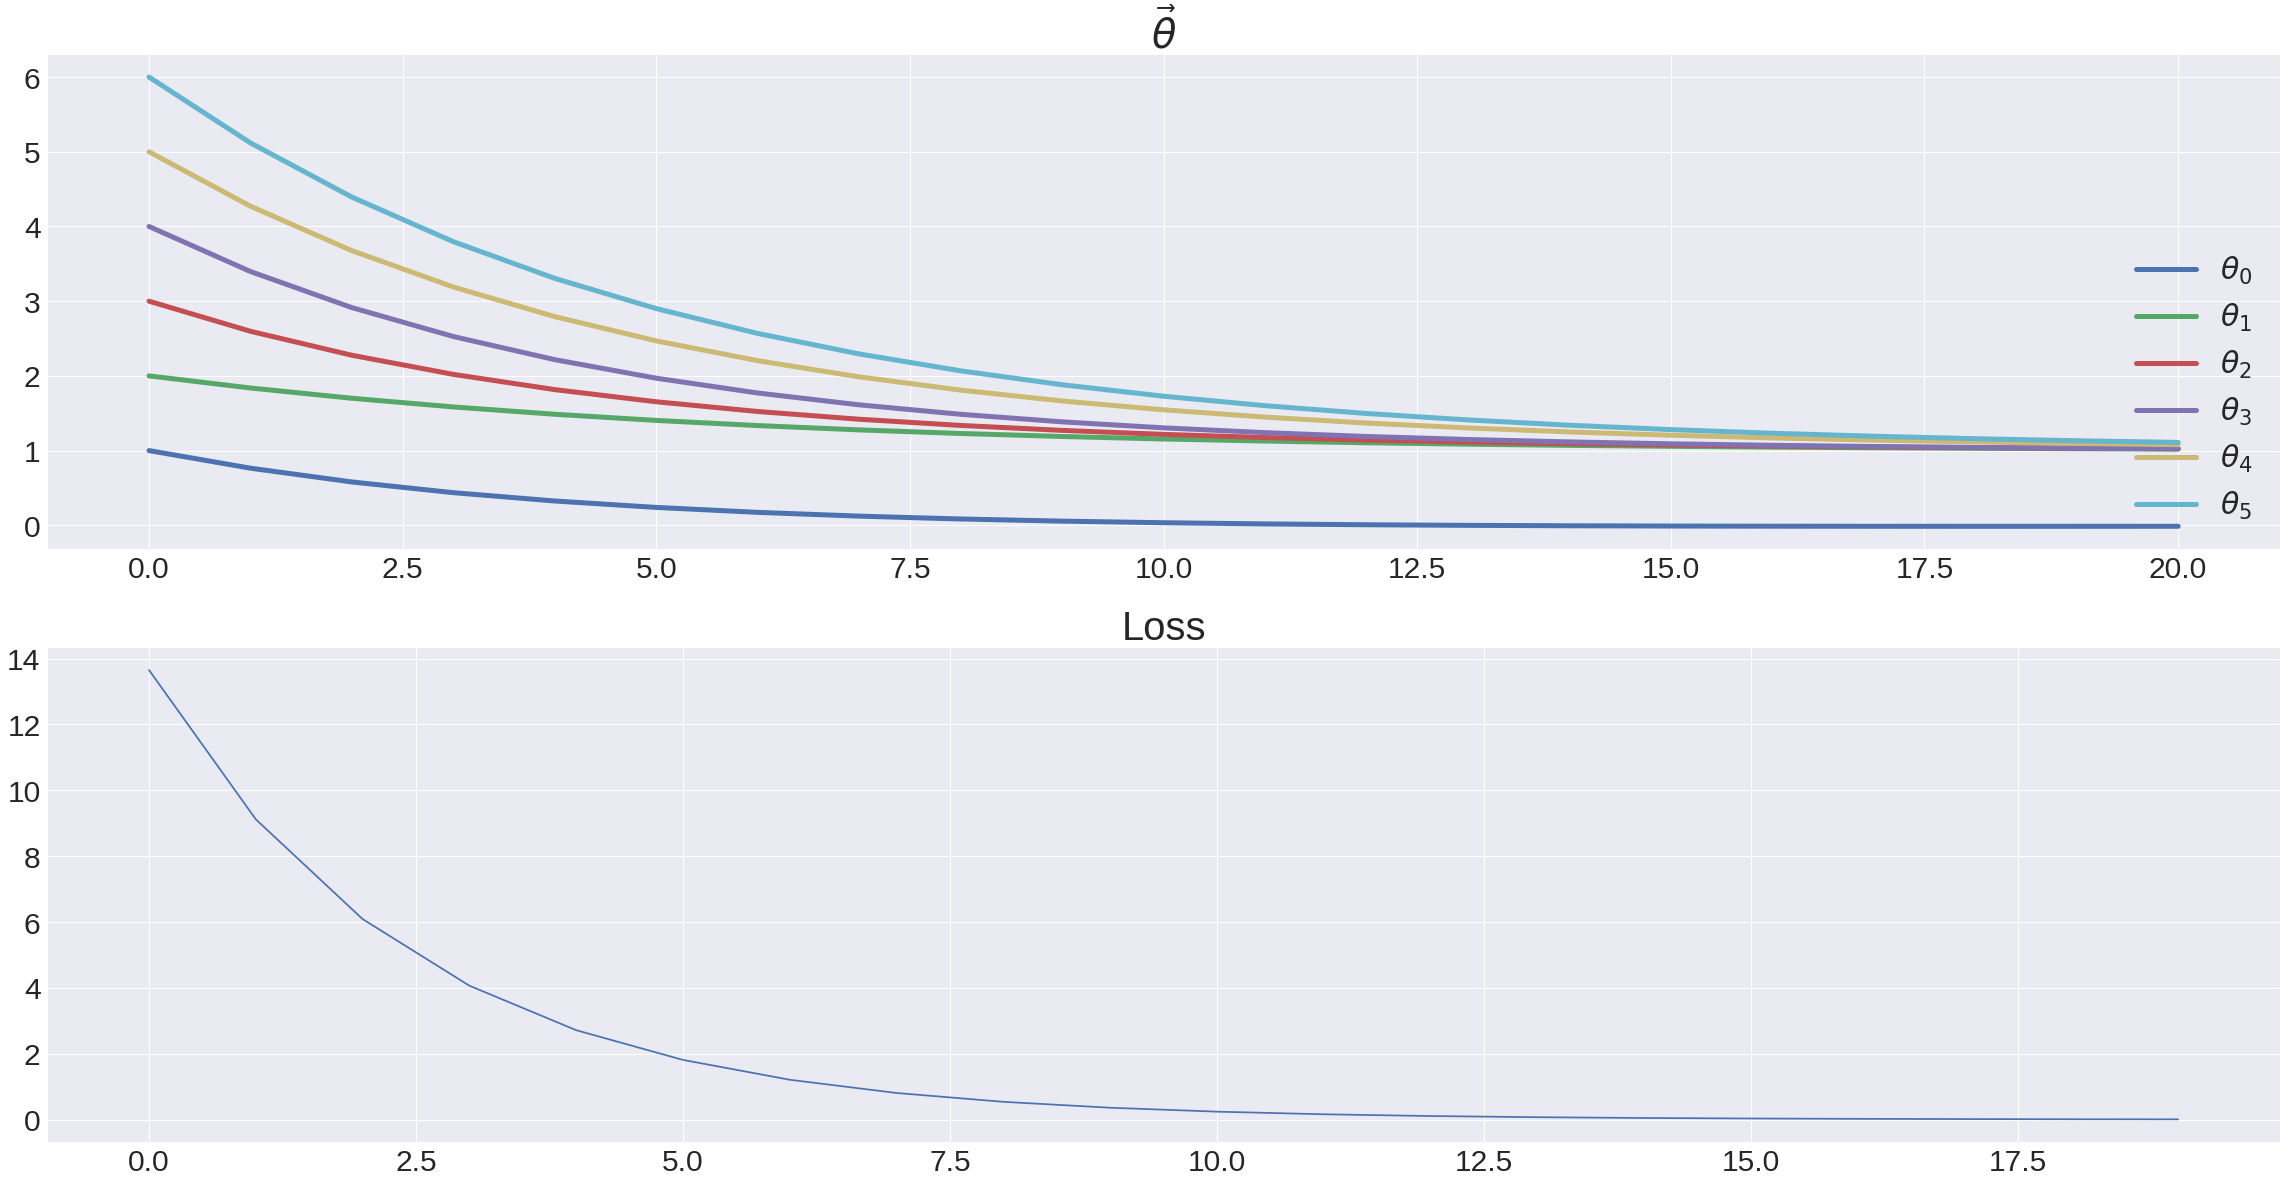

In [88]:
affine = Affine_Function(feature_dim, Th)
loss = Square_Error_Loss()

for epoch in range(epochs):
  for data_idx, (X, y) in enumerate(zip(x_data, y_data)):
    # forward propagation
    pred = affine.forward(X)
    l = loss.forward(y, pred)

    # backpropagation
    dpred = loss.backward()
    affine.backward(dpred, lr)
  
  th_accum = np.hstack((th_accum, affine._Th))
  loss_list.append(l)

result_visualization(th_accum, loss_list)